# Parametric linear elastic equation 

This notebook implements linear elastic deformation of thin plate where Young's modulus is uncertain and sampled from log-normal like distribution. Dependencies are mentioned in the `neuralop.yml` file in the root directory of this repository. 

## Problem description
We consider the in-plane deformation of the thin plate with the center plane given by $\Omega = (0, 1) \times (0, 1) \subset\mathbb{R}^2$. Suppose $E(x)$ is the Young's modulus at a point $x\in \Omega$ and $\nu$ Poisson ratio, $u = (u_1, u_2) : \Omega \to \mathbb{R}^2$ displacement field, $e(x) = \mathrm{sym} \nabla u = (\nabla u + \nabla u^T)/2$ linearized strain, $\sigma(x)$ Cauchy stress, and $b(x)$ body force per unit volume. The equation for $u$ is based on the balance of linear momentum and reads:
\begin{equation}\tag{1}
    \begin{aligned}
        -\nabla \cdot \sigma(x) &= b(x)\,, \qquad & \forall x\in \Omega\,,\\
        \sigma(x) &= \lambda(x) e_{ii} \mathrm{Id} + 2\mu(x) e\,, \qquad & \forall x \in \Omega\,,\\
        u(x) &= 0\,,\qquad &\forall x\in \Gamma_u\,,\\
        \sigma(x) n(x) &= t(x)\,, \qquad &\forall x\in \Gamma_q\,,\\
    \end{aligned}
\end{equation}
where, $\lambda$ and $\mu$ are Lam\'e parameters and are related to $E$ and $\nu$ as follows:
\begin{equation}\tag{2}
    \lambda(x) = \frac{E(x) \nu}{(1+\nu)(1-2\nu)} \quad \text{and} \quad \mu(x) = \frac{E(x)}{2(1+\nu)}\,.
\end{equation}
In Eq (1), $\Gamma_u := \left\{x\in \partial \Omega: x_1 < 1 \right\}$ and $\Gamma_q := \partial \Omega - \Gamma_u$, $n$ unit outward normal, and $t$ specified traction on the right edge of the domain. We assume that the field $E\in M$ is uncertain and the forward map $F: M \to U$ is defined such that given $E\in M$, $F(m) = u \in U$ solves the BVP Eq (1). The probability distribution for $E$ is given by
\begin{equation}\tag{3}
    E = \alpha_m * \log(w) + \mu_m, \qquad \text{where} \quad w \sim N(0, C)\,,
\end{equation}
with $C$ is the covariance operator and takes the same form as in [Poisson problem](../poisson/Poisson.ipynb). 

## Fixing parameters
We let
\begin{equation}\tag{4}
    b(x) = 0 \quad \text{and} \quad t(x) = 0e_1 + 10 e_2 
\end{equation}
and
\begin{equation}\tag{5}
\gamma_C = 0.8\,, \quad \delta_C = 0.2\,,\quad \eta_C = 1\,,\quad d_C = 2\,, \quad \alpha_m = 100\,, \quad \mu_m = 1000\,.
\end{equation}

## Random samples of m and corresponding solution u(m)

<p align="center"> <img src="./data/LinearElasticity_sample_plots.png" width="600"> </p>

In [1]:
import sys
import os
import time
import numpy as np
import dolfin as dl
import hippylib as hp

from scipy.interpolate import griddata

util_path = "../../utilities/"
sys.path.append(util_path)
from plotUtilities import field_plot_fenics

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# set seed
seed = 0
np.random.seed(seed)

In [2]:
data_folder = 'data/'
current_directory = os.getcwd()  
results_dir = current_directory + '/' + data_folder
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

### Plotting functions

In [3]:
import matplotlib.tri as tri
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [4]:
def field_plot_fenics(ax, f, Vh, \
                      plot_absolute = False, \
                      add_displacement_to_nodes = False, \
                      is_displacement = False, \
                      is_fn = False, dbg_log = False, **kwargs):
    
    if is_fn:
        f_fn = f
    else:
        f_fn = dl.Function(Vh)
        f_fn.vector().zero()
        if isinstance(f, np.ndarray):
            f_fn.vector().set_local(f)
        else:
            f_fn.vector().axpy(1.0, f)
    
    mesh = Vh.mesh()
    gdim = mesh.geometry().dim()

    if gdim != 2:
        raise ValueError("Only 2D plots are supported")

    w0 = f_fn.compute_vertex_values(mesh)
    nv = mesh.num_vertices()

    U = [w0[i * nv: (i + 1) * nv] for i in range(gdim)]
    
    if gdim == 2:
        if len(U[gdim - 1]) == 0:
            U = np.array(U[0]).T
        else:
            U = np.array(U).T
    else:
        U = np.array(U).T

    n1, n2 = U.shape[0], 1 if len(U.shape) == 1 else U.shape[1]
    if dbg_log:
        print('n1, n2 = {}, {}'.format(n1, n2))

    nodes = mesh.coordinates()
    elements = mesh.cells()

    # Compute magnitude of the field
    plot_C = None
    if len(U.shape) == 1:
        plot_C = np.sqrt(U[:]**2) if plot_absolute else U[:]
    else:
        for i in range(n2):
            if i == 0:
                plot_C = U[:, i]**2
            else:
                plot_C += U[:, i]**2

        plot_C = np.sqrt(plot_C)

    # manipulate the configuration of the plot
    nodes_def = nodes
    if is_displacement:
        if n2 != 2:
            raise ValueError("Displacement should be a 2D array for dim = 2")

        if add_displacement_to_nodes:
            nodes_def = nodes + U

    if dbg_log:
        print('nodes_def.shape = {}'.format(nodes_def.shape))
    
    triang = tri.Triangulation(nodes_def[:, 0], nodes_def[:, 1], elements)
    shading = kwargs.pop("shading", "gouraud") # or 'shading', 'flat'
    cbar = ax.tripcolor(triang, plot_C, shading=shading, **kwargs)

    return cbar

In [5]:
def field_plot(ax, fn_nodal_values, nodes, elements = None, dim = 2, \
                        plot_absolute = False, \
                        add_displacement_to_nodes = False, \
                        is_displacement = False, \
                        dbg_log = False, **kwargs):
    
    if dim != 2:
        raise ValueError("Only 2D plots are supported")
    
    if dbg_log:
        print('fn_nodal_values.shape = {}, nodes.shape = {}'.format(fn_nodal_values.shape, \
                                                                nodes.shape))
    
    num_nodes = nodes.shape[0]
    num_fn_values = fn_nodal_values.shape[0]

    dof_per_node = num_fn_values // num_nodes
    if dof_per_node == 0:
        raise ValueError("Number of dofs per node is zero")

    # Compute magnitude of the field
    plot_C = None
    if dof_per_node == 1:
        plot_C = np.sqrt(fn_nodal_values[:]**2) if plot_absolute else fn_nodal_values[:]
    else:
        for i in range(dof_per_node):
            if i == 0:
                plot_C = fn_nodal_values[i*num_nodes:(i+1)*num_nodes]**2
            else:
                plot_C += fn_nodal_values[i*num_nodes:(i+1)*num_nodes]**2

        plot_C = np.sqrt(plot_C)

    # do we warp the configuration of domain (i.e., displace the nodal coordinates)?
    nodes_def = nodes.copy()
    if is_displacement:
        if dof_per_node != 2:
            raise ValueError("Expected a vector function")

        if add_displacement_to_nodes:
            nodes_def[:, 0] = nodes[:, 0] + fn_nodal_values[0:num_nodes]
            nodes_def[:, 1] = nodes[:, 1] + fn_nodal_values[num_nodes:2*num_nodes]

    if dbg_log:
        print('nodes_def.shape = {}'.format(nodes_def.shape))
    
    triang = None
    if elements is not None:
        triang = tri.Triangulation(nodes_def[:, 0], nodes_def[:, 1], elements)
    else:
        triang = tri.Triangulation(nodes_def[:, 0], nodes_def[:, 1])

    shading = kwargs.pop("shading", "gouraud") # or 'shading', 'flat'

    cbar = ax.tripcolor(triang, plot_C, shading=shading, **kwargs)

    return cbar

In [6]:
def field_plot_grid(ax, fn_nodal_values, grid_x, grid_y, dim = 2, \
                        plot_absolute = False, \
                        add_displacement_to_nodes = False, \
                        is_displacement = False, \
                        dbg_log = False, **kwargs):
    if dim != 2:
        raise ValueError("Only 2D plots are supported")
    
    # grid_x and grid_y are of shape (nx, ny)
    # fn_nodal_values is of shape (nx, ny) if scalar and (nx, ny, 2) if vector
    nx, ny = grid_x.shape[0], grid_x.shape[1]
    n_comps = 1 if len(fn_nodal_values.shape) == 2 else fn_nodal_values.shape[2]
    if dbg_log:
        print('nx = {}, ny = {}, n_comps = {}'.format(nx, ny, n_comps))

    # we reduce the grid_x and grid_y to 1D arrays and then stack them together
    nodes = np.vstack((grid_x.flatten(), grid_y.flatten())).T
    if dbg_log:
        print('nodes.shape = {}'.format(nodes.shape))

    # also reduce the fn_nodal_values to 1D array
    if n_comps == 1:
        fn_nodal_values = fn_nodal_values.flatten()
    else:
        fn_nodal_values = fn_nodal_values.reshape((nx*ny, n_comps))
    
    # Compute magnitude of the field
    plot_C = None
    if n_comps == 1:
        plot_C = np.sqrt(fn_nodal_values[:]**2) if plot_absolute else fn_nodal_values[:]
    else:
        for i in range(n_comps):
            if i == 0:
                plot_C = fn_nodal_values[:, i]**2
            else:
                plot_C += fn_nodal_values[:, i]**2

        plot_C = np.sqrt(plot_C)

    # manipulate the configuration of the plot
    nodes_def = nodes
    if is_displacement and add_displacement_to_nodes:
        if n_comps != 2:
            raise ValueError("Displacement should be a 2D array for dim = 2")

        nodes_def = nodes + fn_nodal_values

    if dbg_log:
        print('nodes_def.shape = {}'.format(nodes_def.shape))
    
    triang = tri.Triangulation(nodes_def[:, 0], nodes_def[:, 1])

    shading = kwargs.pop("shading", "gouraud") # or 'shading', 'flat'

    cbar = ax.tripcolor(triang, plot_C, shading=shading, **kwargs)

    return cbar

# Main model class
This will also be moved to a python script after testing. The class has two component: (1) class to sample Young's modulus field using log-normal distribution in infinite dimension and (2) class that implements the variational form and solves it. 

In [7]:
class PriorSampler:
    
    def __init__(self, Vm, correlation_length, seed = 0, logn_scale = 100., logn_translate = 1000.):

        self.correlation_length = correlation_length
        var = self.correlation_length / 0.16
        # Delta and gamma
        self.delta = (var * self.correlation_length) ** (-0.5)
        self.gamma = self.delta * self.correlation_length ** 2

        self.seed = seed
        self.Vm = Vm

        self.prior = hp.BiLaplacianPrior(self.Vm, self.gamma, self.delta, robin_bc=True)
        self.translate = dl.Constant(logn_translate)
        self.scale = dl.Constant(logn_scale)
        
        self.parRandom = hp.Random(seed = seed)

        # initialize noise vector
        self.noise = dl.Vector()
        self.prior.init_vector(self.noise, "noise")
        self.parRandom.normal(1.,self.noise)
        
        # initialize sample
        self.sample = dl.Vector()
        self.prior.init_vector(self.sample, 0)

        # draw a sample
        self.parRandom.normal(1.,self.noise)
        self.prior.sample(self.noise, self.sample)

        self.m_local = None
        self.m_fn = dl.Function(self.Vm)
        self.m_transform_fn = dl.Function(self.Vm)

        # set mean
        self.mean = self.prior.mean.copy()
        self.transform(self.mean)

    def transform(self, m):
        self.m_fn.vector().zero()
        self.m_fn.vector().axpy(1., m)
        self.m_transform_fn = self.scale * dl.exp(self.m_fn) + self.translate
        
        self.m_local = dl.project(self.m_transform_fn, self.Vm).vector().get_local()
        m.set_local(self.m_local)


    def transform_pointwise(self, m):
        self.m_local = self.scale.values()[0]*np.exp(m.get_local()) + self.translate.values()[0]
        m.set_local(self.m_local)

    def get(self):
        self.sample.zero()
        self.parRandom.normal(1.,self.noise)
        self.prior.sample(self.noise, self.sample)

        self.transform_pointwise(self.sample)
        return self.sample
    
class LinearElasticityModel:
    
    def __init__(self, correlation_length, seed = 0):
        
        # FE setup
        self.fe_order = 1
        self.nx = 50
        self.ny = 50
        self.mesh = dl.RectangleMesh(dl.Point(0, 0), dl.Point(1,1), self.nx, self.ny)
        self.Vu = dl.VectorFunctionSpace(self.mesh, "Lagrange", self.fe_order)
        self.Vm = dl.FunctionSpace(self.mesh, "Lagrange", self.fe_order)
        self.Vh = [self.Vu, self.Vm, self.Vu] # state, parameter, adjoint

        # Boundary conditions
        self.b = dl.Constant((0, 0))
        self.t = dl.Constant((0, 10))
        
        self.bc = [dl.DirichletBC(self.Vu, dl.Constant((0,0)), self.boundaryLeft)]

        facets = dl.MeshFunction("size_t", self.mesh, self.mesh.topology().dim()-1)
        dl.AutoSubDomain(self.boundaryRight).mark(facets, 1)
        self.ds = dl.Measure("ds", domain=self.mesh, subdomain_data=facets)

        # variational form
        self.m_fn = dl.Function(self.Vm)
        self.u_fn = dl.Function(self.Vu)
        self.nu = 0.25
        self.lam_fact = dl.Constant(self.nu / (1+self.nu)*(1-2*self.nu))
        self.mu_fact = dl.Constant(1/(2*(1+self.nu)))
        
        self.u_trial = dl.TrialFunction(self.Vu)
        self.u_test = dl.TestFunction(self.Vu)

        self.d = self.u_fn.geometric_dimension()  # space dimension
        self.a = self.m_fn*dl.inner(self.lam_fact*dl.tr(dl.grad(self.u_trial))*dl.Identity(self.d) \
                                        + 2*self.mu_fact * dl.sym(dl.grad(self.u_trial)), \
                                    dl.sym(dl.grad(self.u_test)))*dl.dx
        
        self.L = dl.inner(self.b, self.u_test)*dl.dx + dl.inner(self.t, self.u_test)*self.ds 

        self.varf = self.a - self.L
    
        # setup prior for parameter field m
        self.prior_sampler = PriorSampler(self.Vm, correlation_length, seed)
        
    @staticmethod
    def boundaryLeft(x, on_boundary):
        return on_boundary and dl.near(x[0], 0.)
    
    @staticmethod
    def boundaryRight(x, on_boundary):
        return on_boundary and dl.near(x[0], 1.)
    
    def epsilon(self):
        return dl.sym(dl.grad(self.u_fn))

    def sigma(self):
        return self.m_fn*self.lam_fact*dl.tr(dl.grad(self.u_fn))*dl.Identity(self.d) \
                                        + 2*self.m_fn*self.mu_fact * dl.sym(dl.grad(self.u_fn))

    def solveFwd(self, m = None, m_is_fn = True):
        if m is not None:
            self.m_fn.vector().zero()
            if m_is_fn:
                self.m_fn.vector().axpy(1., m.vector())
            else:
                self.m_fn.vector()[:] = m


        self.A = dl.assemble(self.a)
        self.b = dl.assemble(self.L)
        for bc in self.bc:
            bc.apply(self.A, self.b)
        
        dl.solve(self.A, self.u_fn.vector(), self.b)

    def samplePrior(self):
        self.m_fn.vector().zero()
        self.m_fn.vector().axpy(1., self.prior_sampler.get())

# Test LinearElasticity model

In [ ]:
correlation_length = 2
model_name = 'LinearElasticity'
model = LinearElasticityModel(correlation_length)
print(model.prior_sampler.gamma, model.prior_sampler.delta)

0.8 0.2


## Generate few samples of Youngs modulus and solve the forward problem

In [9]:
m_fn = dl.Function(model.Vm)
m_fn.vector().axpy(1., model.prior_sampler.mean)

model.solveFwd(m_fn, m_is_fn = True)
u_fn = model.u_fn
u_vv = u_fn.compute_vertex_values()
print('u_vv shape = {}'.format(u_vv.shape))


u_vv shape = (5202,)


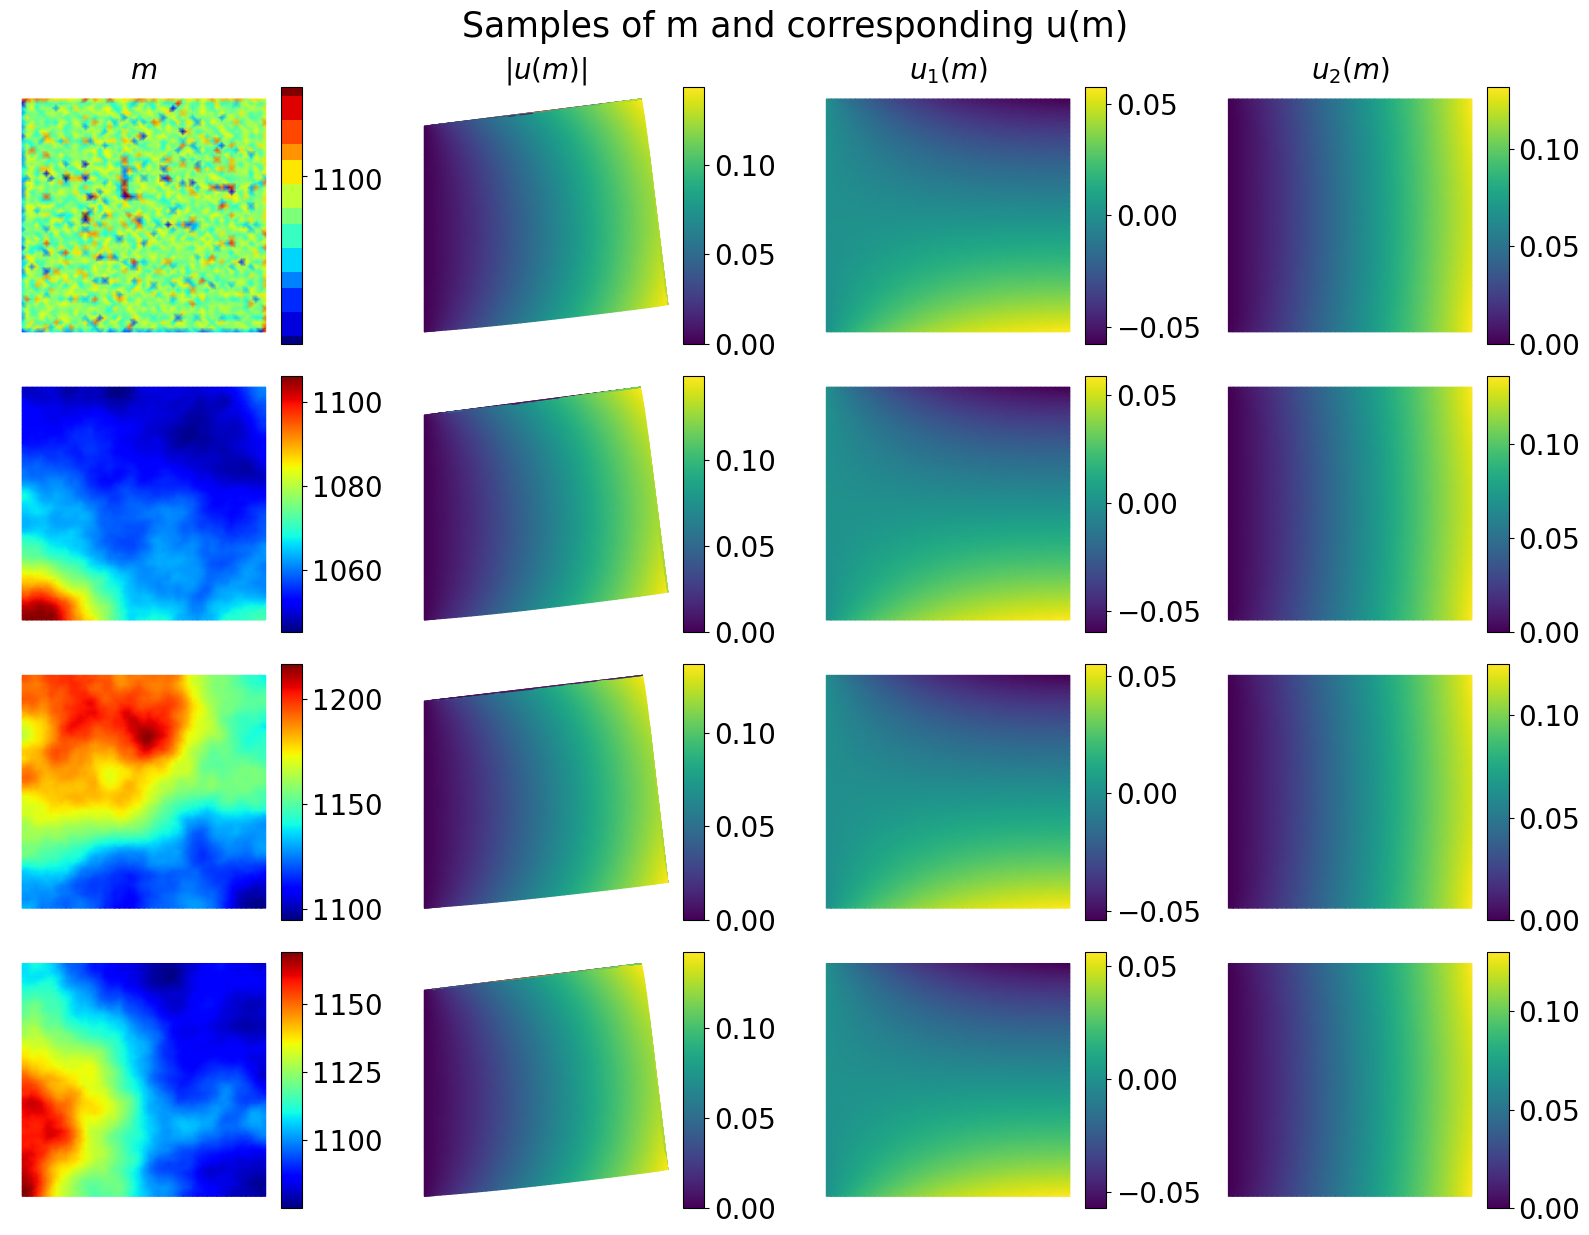

In [10]:
rows = 4
cols = 4 # m, |u(m)|, u1, u2
fs = 20
fig, axs = plt.subplots(rows, cols, figsize=(16, 12))

u_vec = None
u_tag = [r'$m$', r'$|u(m)|$', r'$u_1(m)$', r'$u_2(m)$']
cmap_vec = ['jet', 'viridis', 'viridis', 'viridis']

m_fn = dl.Function(model.Vm)
u_fn = dl.Function(model.Vu)

for i in range(rows):

    m_fn.vector().zero()
    if i > 0:
        m_fn.vector().axpy(1., model.prior_sampler.get())
    else:
        m_fn.vector().axpy(1., model.prior_sampler.mean)
    
    model.solveFwd(m_fn, m_is_fn = True)
    u_fn = model.u_fn
    u1_fn = model.u_fn.sub(0)
    u2_fn = model.u_fn.sub(1)
    
    u_vec = [m_fn, u_fn, u1_fn, u2_fn]

    use_fenics_plot = False

    for j in range(cols):
        V = model.Vu
        if j == 0:
            V = model.Vm

        # use V mesh
        nodes = V.mesh().coordinates()
        # or 
        # nodes = model.mesh.coordinates()


        if j == 1:
            # displacement magnitude and domain warped by displacement (current configuration)
            if use_fenics_plot:
                cbar = field_plot_fenics(axs[i,j], \
                        u_vec[j].vector(), \
                        V, \
                        cmap = cmap_vec[j], \
                        add_displacement_to_nodes = True, \
                        is_displacement = True)
            else:
                u_vv = u_vec[j].compute_vertex_values()
                cbar = field_plot(axs[i,j], \
                        u_vv, \
                        nodes, \
                        cmap = cmap_vec[j], \
                        add_displacement_to_nodes = True, \
                        is_displacement = True)
        else:
            if use_fenics_plot:
                cbar = field_plot_fenics(axs[i,j], \
                        u_vec[j].vector(), \
                        V, \
                        cmap = cmap_vec[j])
            else:
                u_vv = u_vec[j].compute_vertex_values()
                cbar = field_plot(axs[i,j], \
                        u_vv, \
                        nodes, \
                        cmap = cmap_vec[j])
        
        divider = make_axes_locatable(axs[i,j])
        cax = divider.append_axes('right', size='8%', pad=0.03)
        cax.tick_params(labelsize=fs)

        if j== 0:
            # format cbar ticks
            kfmt = lambda x, pos: "{:g}".format(x)
            
            cbar = fig.colorbar(cbar, cax=cax, orientation='vertical', format = kfmt)
        else:
            cbar = fig.colorbar(cbar, cax=cax, orientation='vertical')
        
        if i == 0:
            axs[i,j].set_title(u_tag[j], fontsize=fs)
        axs[i,j].axis('off')

fig.tight_layout()
fig.suptitle('Samples of m and corresponding u(m)', fontsize=1.25*fs, y=1.025)
fig.savefig(results_dir+'LinearElasticity_sample_plots.png',  bbox_inches='tight')
plt.show()

In [11]:
a = model.prior_sampler.mean.get_local()
print('mean:', a.mean(), a.min(), a.max())
a = model.prior_sampler.get().get_local()
print('sample:', a.mean(), a.min(), a.max())

mean: 1099.9999999999993 1099.9999999999964 1100.0000000000018
sample: 1148.3446922348544 1086.3289372951315 1269.918122858995


## Generate data

In [12]:
m = dl.Function(model.Vm).vector()
m.axpy(1., model.prior_sampler.mean)

model.solveFwd(m, m_is_fn = False)

u1, u2 = model.u_fn.sub(0, deepcopy=True), model.u_fn.sub(1, deepcopy=True)
u1_vec = u1.vector().get_local()
u2_vec = u2.vector().get_local()

u1_size = u1_vec.shape[0]
u2_size = u2_vec.shape[0]
print('u1_size:', u1_size, 'u2_size:', u2_size)


u1_size: 2601 u2_size: 2601


In [ ]:
generate_data = False
if generate_data:
    num_samples = 2000

    m_samples = np.zeros((num_samples, model.Vm.dim()))
    u_samples = np.zeros((num_samples, model.Vu.dim()))

    m_fn = dl.Function(model.Vm)
    u_fn = dl.Function(model.Vu)

    for i in range(num_samples):

        start_time = time.perf_counter()

        m_fn.vector().zero()
        if i > 0:
            m_fn.vector().axpy(1., model.prior_sampler.get())
        else:
            m_fn.vector().axpy(1., model.prior_sampler.mean)
        
        model.solveFwd(m_fn, m_is_fn = True)
        u = model.u_fn

        # save
        m_samples[i, :] = m_fn.compute_vertex_values()
        u_samples[i, :] = u_fn.compute_vertex_values()

        end_time = time.perf_counter()
        sample_time = end_time - start_time

        if i % 100 == 0:
            print('Sample {:4d} took {:.3f} seconds'.format(i, sample_time))

    print(m_samples.shape, u_samples.shape)

Sample    0 took 0.158 seconds
Sample  100 took 0.041 seconds
Sample  200 took 0.055 seconds
Sample  300 took 0.056 seconds
Sample  400 took 0.043 seconds
Sample  500 took 0.057 seconds
Sample  600 took 0.039 seconds
Sample  700 took 0.049 seconds
Sample  800 took 0.048 seconds
Sample  900 took 0.155 seconds
Sample 1000 took 0.044 seconds
Sample 1100 took 0.059 seconds
Sample 1200 took 0.046 seconds
Sample 1300 took 0.063 seconds
Sample 1400 took 0.054 seconds
Sample 1500 took 0.040 seconds
Sample 1600 took 0.044 seconds
Sample 1700 took 0.040 seconds
Sample 1800 took 0.054 seconds
Sample 1900 took 0.042 seconds
(2000, 2601) (2000, 5202)


In [ ]:
if generate_data:
    # data to save
    np.savez(results_dir + model_name + '_samples.npz', \
            m_samples = m_samples, \
            u_samples = u_samples, num_samples = num_samples, \
            m_dim = model.Vm.dim(), u_dim = model.Vu.dim(), \
            fe_order = model.fe_order, nx = model.nx, ny = model.ny, \
            correlation_length = correlation_length, \
            gamma = model.prior_sampler.gamma, \
            delta = model.prior_sampler.delta, \
            alpha_m = model.prior_sampler.scale.values()[0], \
            mu_m = model.prior_sampler.translate.values()[0], \
            u_mesh_nodes = model.Vu.mesh().coordinates(), \
            m_mesh_nodes = model.Vm.mesh().coordinates(), \
            u_mesh_elements = model.Vu.mesh().cells(), \
            m_mesh_elements = model.Vm.mesh().cells())


    # save mesh 
    ## to read, use the syntax
    ## mesh = dl.Mesh()
    ## with dl.XDMFFile(results_dir + 'u_mesh.xdmf') as infile:
    ##     infile.read(mesh)
    with dl.XDMFFile(results_dir + model_name + '_u_mesh.xdmf') as infile:
        infile.write(model.Vu.mesh())

    with dl.XDMFFile(results_dir + model_name + '_m_mesh.xdmf') as infile:
        infile.write(model.Vm.mesh())

In [15]:
print('m_mesh_nodes shape: {}\nu_mesh_nodes shape: {}\nm_dim: {}\nu_dim: {}'.format(model.Vm.mesh().coordinates().shape, model.Vu.mesh().coordinates().shape, model.Vm.dim(), model.Vu.dim()))

m_mesh_nodes shape: (2601, 2)
u_mesh_nodes shape: (2601, 2)
m_dim: 2601
u_dim: 5202


## Interpolate function at nodal values to meshgrid for FNO

### Compute and plot interpolation over grid

[]

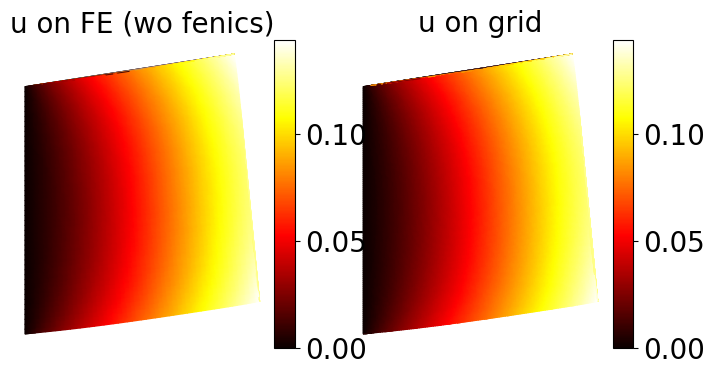

In [ ]:
data_load = np.load(results_dir + model_name + '_samples.npz')
fe_u_nodes = data_load['u_mesh_nodes']
num_nodes = fe_u_nodes.shape[0]

# get one sample
m_fn = dl.Function(model.Vm)
m_fn.vector().axpy(1., model.prior_sampler.mean)
model.solveFwd(m_fn, m_is_fn = True)
u_fn = model.u_fn

u = u_fn.compute_vertex_values()

# use interpolation to get data on grid
num_grid_x, num_grid_y = 121, 121
grid_x, grid_y = np.meshgrid(np.linspace(0, 1, num_grid_x), np.linspace(0, 1, num_grid_y))

# interpolate u on grid
grid_u = np.zeros((num_grid_x, num_grid_y, 2))
grid_u[:, :, 0] = griddata(fe_u_nodes, u[:num_nodes], (grid_x, grid_y), method='linear')
grid_u[:, :, 1] = griddata(fe_u_nodes, u[num_nodes:], (grid_x, grid_y), method='linear')

# plot function on FE mesh with and without fenics and compare with the function on grid

rows = 1
cols = 2
fs = 20
fig, axs = plt.subplots(rows, cols, figsize=(8, 4))

for i in range(cols):
    
    if i == 0:
        # use plotter without element data
        cbar = field_plot(axs[i], \
                        u, \
                        fe_u_nodes, \
                        cmap = 'hot', \
                        add_displacement_to_nodes = True, \
                        is_displacement = True)
        axs[i].set_title('u on FE (wo fenics)', fontsize = fs)
    else:
        # use griddata
        cbar = field_plot_grid(axs[i],\
                        grid_u, \
                        grid_x, \
                        grid_y, \
                        cmap = 'hot', \
                        add_displacement_to_nodes = True, \
                        is_displacement = True)
        axs[i].set_title('u on grid', fontsize = fs)

    divider = make_axes_locatable(axs[i])
    cax = divider.append_axes('right', size='8%', pad=0.03)
    cax.tick_params(labelsize=fs)
    cbar = fig.colorbar(cbar, cax=cax, orientation='vertical')

    axs[i].axis('off')

plt.plot()


### Interpolate all samples to grid and save to file for FNO

In [17]:
# save all samples to file
generate_fno_data = False
if generate_fno_data:

    num_grid_x, num_grid_y = 121, 121
    print('Generating FNO data for grid sizes ({}, {})'.format(num_grid_x, num_grid_y))

    # get grid coordinates
    grid_x, grid_y = np.meshgrid(np.linspace(0, 1, num_grid_x), np.linspace(0, 1, num_grid_y))

    # load data
    data_load = np.load(results_dir + model_name + '_samples.npz')
    
    fe_m_nodes = data_load['m_mesh_nodes']
    fe_u_nodes = data_load['u_mesh_nodes']
    num_nodes = fe_u_nodes.shape[0]

    m_samples = data_load['m_samples']
    u_samples = data_load['u_samples']

    num_samples = m_samples.shape[0]
    
    # interpolate samples on grid
    grid_m_samples = np.zeros((num_samples, num_grid_x, num_grid_y))
    grid_u_samples = np.zeros((num_samples, num_grid_x, num_grid_y, 2))
    for i in range(num_samples):
        start_time = time.perf_counter()
        
        grid_m_samples[i, :, :] = griddata(fe_m_nodes, m_samples[i, :], (grid_x, grid_y), method='linear')
        grid_u_samples[i, :, :, 0] = griddata(fe_u_nodes, u_samples[i, :num_nodes], (grid_x, grid_y), method='linear')
        grid_u_samples[i, :, :, 1] = griddata(fe_u_nodes, u_samples[i, num_nodes:], (grid_x, grid_y), method='linear')

        end_time = time.perf_counter()
        sample_time = end_time - start_time

        if i % 100 == 0:
            print('Sample {:4d} took {:.3f} seconds'.format(i, sample_time))

    print(grid_m_samples.shape, grid_u_samples.shape)

Generating FNO data for grid sizes (121, 121)
Sample    0 took 0.105 seconds
Sample  100 took 0.099 seconds
Sample  200 took 0.098 seconds
Sample  300 took 0.092 seconds
Sample  400 took 0.102 seconds
Sample  500 took 0.109 seconds
Sample  600 took 0.106 seconds
Sample  700 took 0.093 seconds
Sample  800 took 0.110 seconds
Sample  900 took 0.113 seconds
Sample 1000 took 0.091 seconds
Sample 1100 took 0.105 seconds
Sample 1200 took 0.103 seconds
Sample 1300 took 0.106 seconds
Sample 1400 took 0.098 seconds
Sample 1500 took 0.102 seconds
Sample 1600 took 0.097 seconds
Sample 1700 took 0.096 seconds
Sample 1800 took 0.107 seconds
Sample 1900 took 0.090 seconds
(2000, 121, 121) (2000, 121, 121, 2)


In [18]:
# data to save
if generate_fno_data:
        np.savez(results_dir + model_name + '_FNO_samples.npz', \
                grid_m_samples = grid_m_samples, \
                grid_u_samples = grid_u_samples, \
                num_samples = num_samples, \
                num_grid_x = num_grid_x, num_grid_y = num_grid_y, \
                grid_x = grid_x, grid_y = grid_y)

NameError: name 'model_name' is not defined

### Load data to test

In [ ]:
data_load = np.load(results_dir + model_name + '_samples.npz')

print('num_samples: {}\nm_samples shape: {}\nu_samples shape: {}\nm_dim: {}\nu_dim: {}'.format(data_load['num_samples'], data_load['m_samples'].shape, data_load['u_samples'].shape, data_load['m_dim'], data_load['u_dim']))

((2000, 2601), (2000, 5202), array(2601), array(5202))